In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os
import matplotlib.pyplot as plt
import numpy as np

/home/ubuntu/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def variable_init(size):
    in_dim = size[0]
    
    s_sddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=s_sddev)

In [3]:
X = tf.placeholder(tf.float32, shape=[None, 784])

D_W1 = tf.Variable(initial_value=variable_init([784, 128]))
D_b1 = tf.Variable(initial_value=tf.zeros(shape=[128]))

D_W2 = tf.Variable(initial_value=variable_init([128, 1]))
D_b2 = tf.Variable(initial_value=tf.zeros(shape=[1]))

thelta_D = [D_W1, D_b1, D_W2, D_b2]

Z = tf.placeholder(dtype=tf.float32, shape=[None, 100])

G_W1 = tf.Variable(initial_value=variable_init([100, 128]))
G_b1 = tf.Variable(initial_value=tf.zeros(shape=[128]))

G_W2 = tf.Variable(initial_value=variable_init([128, 784]))
G_b2 = tf.Variable(initial_value=tf.zeros(shape=[784]))

thelta_G = [G_W1, G_b1, G_W2, G_b2]

In [4]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n]).astype('float32')

In [5]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    
    G_pre_h2 = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_pre_h2)
    return G_prob

In [6]:
def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    return D_prob, D_logit

In [7]:
G_sample = generator(Z)

D_real, D_real_logit = discriminator(X)
D_fake, D_fake_logit = discriminator(G_sample)

D_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logit, labels=tf.ones_like(D_real_logit)))
D_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logit, labels=tf.zeros_like(D_fake_logit)))
D_loss = D_real_loss + D_fake_loss

G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logit, labels=tf.ones_like(D_fake_logit)))

D_optimizer = tf.train.AdamOptimizer().minimize(D_loss, var_list=thelta_D)
G_optimizer = tf.train.AdamOptimizer().minimize(G_loss, var_list=thelta_G)

In [8]:
batch_size = 128
Z_dim = 100

mnist = input_data.read_data_sets('../data/MNIST_data', one_hot=True)

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz


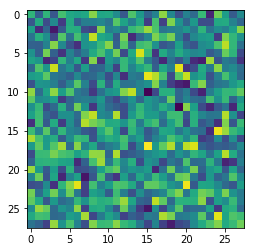

i 0, D_loss_curr 1.6631214618682861, G_loss_curr 2.416898727416992


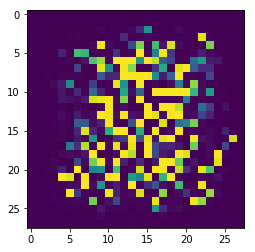

i 2000, D_loss_curr 0.004733232315629721, G_loss_curr 7.616156578063965


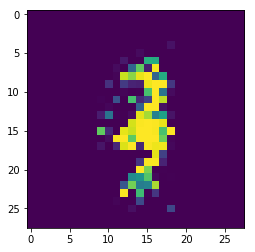

i 4000, D_loss_curr 0.0507039949297905, G_loss_curr 5.8324785232543945


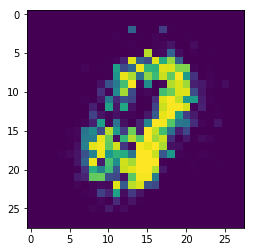

i 6000, D_loss_curr 0.1335805058479309, G_loss_curr 4.97321081161499


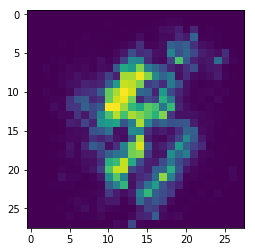

i 8000, D_loss_curr 0.37308967113494873, G_loss_curr 3.734473466873169


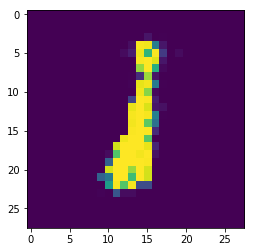

i 10000, D_loss_curr 0.5840632915496826, G_loss_curr 3.4762585163116455


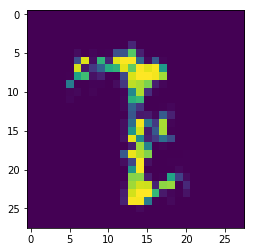

i 12000, D_loss_curr 0.4705464839935303, G_loss_curr 3.2353436946868896


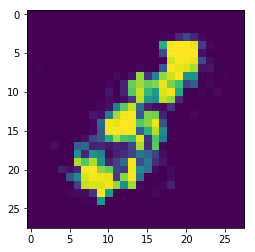

i 14000, D_loss_curr 0.4582877457141876, G_loss_curr 2.3601808547973633


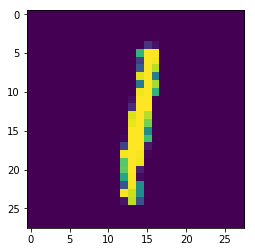

i 16000, D_loss_curr 0.5149139761924744, G_loss_curr 2.4697554111480713


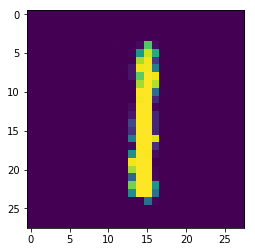

i 18000, D_loss_curr 0.576610803604126, G_loss_curr 2.168476104736328


In [18]:
# 随机生成的sample，通过G后可以被D判定为真实的数据，G的input都是随机数
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out'):
    os.makedirs('out')
    
for i in range(20000):
    if i % 2000 == 0:
        G_display = sess.run(G_sample, feed_dict={Z: sample_Z(1, Z_dim)})[0]
        G_display = G_display.reshape(28, 28)
        plt.imshow(G_display)
        plt.show()
    X_batch, _ = mnist.train.next_batch(batch_size)
    _, D_loss_curr = sess.run([D_optimizer, D_loss], feed_dict={X: X_batch, Z: sample_Z(batch_size, Z_dim)})
    _, G_loss_curr = sess.run([G_optimizer, G_loss], feed_dict={Z: sample_Z(batch_size, Z_dim)})
    
    if i % 2000 == 0:
        print('i {}, D_loss_curr {}, G_loss_curr {}'.format(i, D_loss_curr, G_loss_curr))